In [3]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# Ejercicio 1: Correlación

#### (a) Grafico de dispersion para pixeles vecinos

In [ ]:
#Funcion para formar bloques de pixeles vecinos
def escala_de_grises(path):
    return Image.open(path).convert("L")

def conversion_float(img):
    return np.array(img, dtype = np.float32) / 255.0

def formar_bloques(img):
    X1 = []
    X2 = []
    for i in range(len(img)): #itero por fila de la imagen
        if i % 2 == 0: #si la fila es par
            X1.extend(img[i]) #agrego sus pixeles a X1
        else:
            X2.extend(img[i])
    return np.array([X1, X2])

#Funcion para graficar la imagen y el grafico de dispersion
def grafico_dispersion(X, img, title1, title2):

    fig, axes = plt.subplots(1, 2, figsize = (10, 5))

    # Imagen en grises
    axes[0].imshow(img, cmap = "gray")
    axes[0].set_title(f"{title1}")
    axes[0].axis("off")

    # Gráfico de dispersión
    axes[1].scatter(X[0], X[1], s= 1, alpha = 0.5, color = "darkblue")
    axes[1].set_xlabel("X1")
    axes[1].set_ylabel("X2")
    axes[1].set_title(f"{title2}")

    plt.tight_layout()
    plt.show()


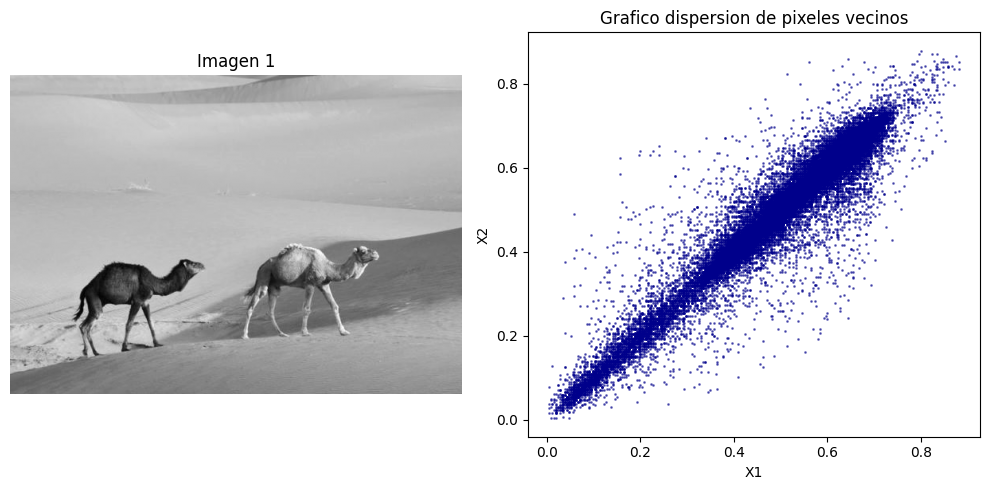

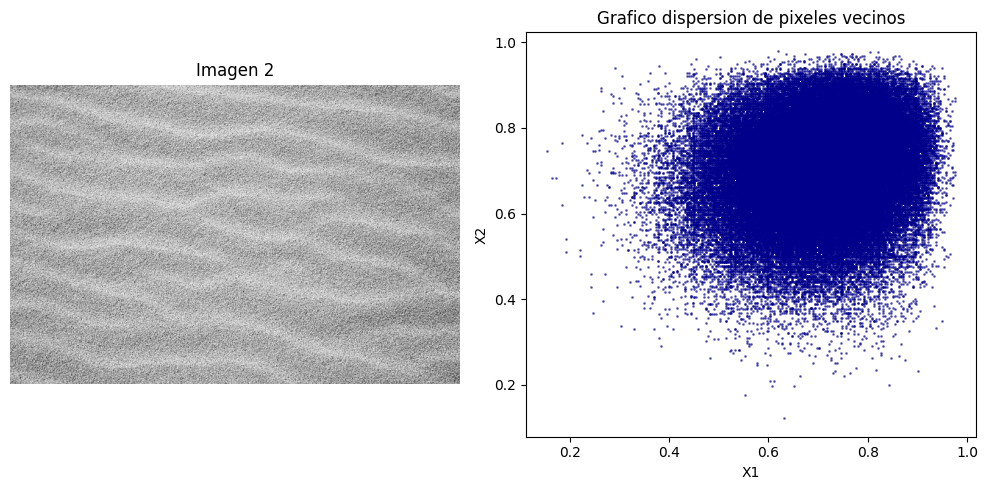

In [8]:
if __name__ == "__main__":
    img1 = escala_de_grises("img_01.jpg")
    img2 = escala_de_grises("img_02.jpg")
    
    #Convertir a float
    img1_float = conversion_float(img1)
    img2_float = conversion_float(img2) # astype(float)

    #Grafico de dispersion para pixeles vecinos
    bloques1 = formar_bloques(img1_float)
    bloques2 = formar_bloques(img2_float)

    grafico_dispersion(bloques1, img1_float, "Imagen 1", "Grafico dispersion de pixeles vecinos")
    grafico_dispersion(bloques2, img2_float, "Imagen 2", "Grafico dispersion de pixeles vecinos")
    

#### (b) Estimacion del coeficiente de correlacion

In [6]:
def coef_correlacion(X):
    return np.corrcoef(X[0], X[1])[0,1]

In [ ]:
if __name__ == "__main__":
    coef_correlacion_img1 = coef_correlacion(bloques1)
    coef_correlacion_img2 = coef_correlacion(bloques2)

    print(f"Coeficiente de correlacion img1: {coef_correlacion_img1}")
    print(f"Coeficiente de correlacion img2: {coef_correlacion_img2}")

#COMPLETAR CONCLUSION

Coeficiente de correlacion img1: 0.9792211339601858
Coeficiente de correlacion img2: 0.14585373552461373


##### Observamos que para la imagen uno, los pixeles vecinos estan altamente correlacionados, lo que significa que al conocer un pixel podemos deducir de el, el valor de su pixel vecino, por lo que hay redundancia. Se puede comprimir con  alta eficiencia y manteniendo la calidad

##### Por otro lado, para la segunda imagen, ocurre el caso contrario. Los pixeles están poco correlacionados, lo que signufica que son independientes, por lo que no se puede deducir el valor de un pixel basandose en su vecino. Esto implica el aumento de bits para comprimir la imagen....

#### (c) Desacoplar 

In [ ]:
def desacoplar(X):
    #Aplicacion de la transformacion Y = P^tX
    mu = X.mean(axis = 1, keepdims = True) #opero fila por fila 
    Xc = X - mu #centrado en la media 

    #calculo covarianza entre pixeles vecinos
    Cx = (Xc @ Xc.T)/ (Xc.shape[1] -1) #hago descomposicion espectral pra conseguir autovectores y autovaores
    autovalores, P = np.linalg.eig(Cx)  #autovalores, autovectores col

    #Obtenemos vector Y descorrelacionado
    Y = P.T @ Xc
    return Y, P, autovalores, mu

#Xc.shape[1] -1) -> Dividimos por N -1 (usamos el estimador insesgado)
#Xc.shape[1] = numero de columnas = N muestras

[[ 0.17692389  0.17692389  0.17692389 ... -0.14196193 -0.15027975
  -0.1558257 ]
 [-0.02461156 -0.02461156 -0.02461156 ... -0.03860193 -0.04137818
  -0.04138034]]


##### Tras aplicar la descorrelacion por PCA, en ambos casos se logra la descorrelación de las variables, lo cual se evidencia en la ausencia de la nube inclinada. Sin embargo, en la primer imagen la varianza queda concentrada casi totalmente en la componente vertical, indicando que originalmente existía una correlación más fuerte entre los píxeles vecinos. En la segunda imagen, aunque también predomina la componente vertical, la dispersión es mayor en la otra dirección, lo que refleja que la correlación inicial entre píxeles era menor

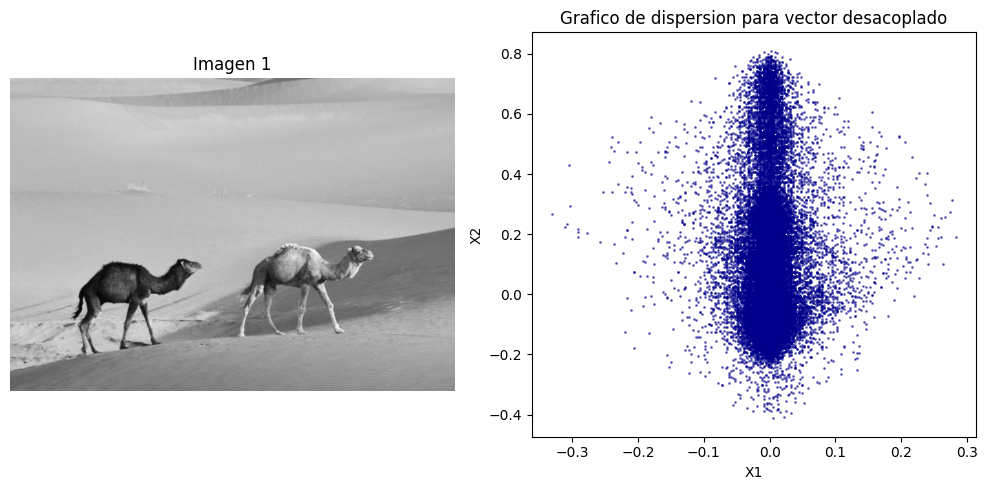

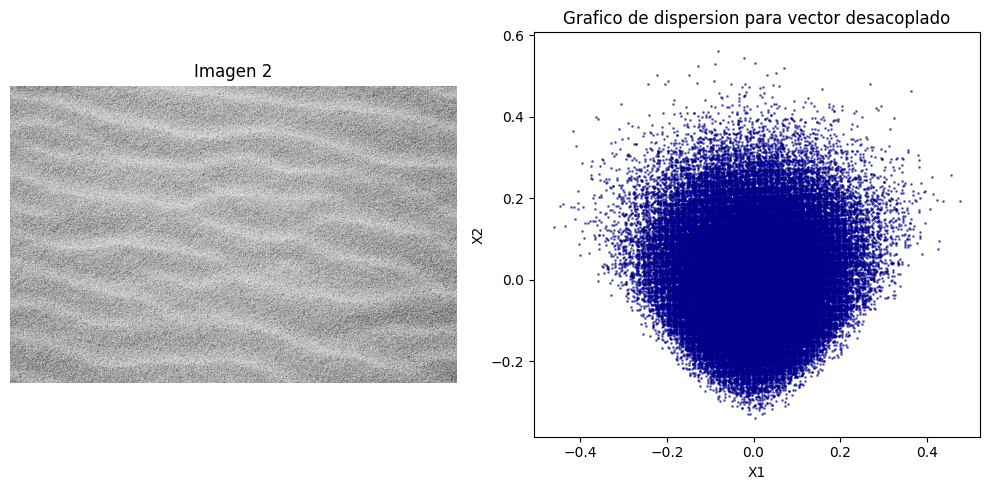

In [9]:
if __name__ == "__main__":
    #imagen desacoplada
    Y1 = desacoplar(bloques1)
    Y2 = desacoplar(bloques2)

    grafico_dispersion(Y1, img1_float, "Imagen 1", "Grafico de dispersion para vector desacoplado")
    grafico_dispersion(Y2, img2_float, "Imagen 2", "Grafico de dispersion para vector desacoplado")

# Ejercicio 2: Compresion

In [ ]:

def pca_transform(X,n):
    # A = USV^t
    Y, P, autovalores = desacoplar(X)
    
    #ordenamiento de las realizaciones xi
    

# Ejercicio 3: Descompresion

In [ ]:
def descompresion(P,mu, Y):
    #Xk = PkYk + mux
    return P @ Y + mu

In [ ]:
def reconstruccion(X_reconstruido,filas,columnas):
    #Creacion de una matriz de 0 = imagen en blanco 
    img_reconstruida = np.zeros((filas, columnas), dtype=float)
    k = 0
    for i in range(filas -1):
        for j in range(columnas):
            img_reconstruida[i][j] = X_reconstruido[0][k]
            img_reconstruida[i+1][j] = X_reconstruido[1][k]
            k += 1
    return img_reconstruida

#img_rec = reconstruccion(descompresion(P,mu,Y), *img1_float.shape)
